# Notebook pre steps

In [1]:
#@title Installations

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection (or line if no selection): Cmd+Shift+Enter

# install missing packages
!pip install dfply

from dfply import *
from plotnine import *
import numpy as np  # RNG and vector ops
import pandas as pd  # tabular outputs
import json
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 13.9 MB/s eta 0:00:00


In [2]:
#@title MDP class

import random
from collections import defaultdict
import numpy as np
import pandas as pd
import json
from pathlib import Path

class MDP:
    """
    A class representing a Markov Decision Process (MDP) using defaultdict structures.

    This implementation includes state management, action specification, transition
    probabilities, rewards, policies, and iterative algorithms for policy and value iteration.
    """

    def __init__(self):
        """
        Initializes an empty MDP with model and state values.
        """
        self.model = defaultdict(lambda: {"pi": None, "actions": defaultdict(dict)})
        self.v = defaultdict(float)

    def add_state_space(self, states):
        """
        Adds states to the MDP.

        Args:
            states (list): List of state identifiers (strings or convertible to strings).
        """
        for state in states:
            _ = self.model[str(state)]
        self.set_state_value()

    def add_action_space(self, state_str, actions):
        """
        Adds actions to a given state. Note you have to update the action
        afterwards using `add_action`.

        Args:
            state_str (str): The state identifier.
            actions (list): List of action identifiers.
        """
        if not isinstance(state_str, str):
            raise ValueError("State is not a sting!")
        if isinstance(actions, str):
            # If it's a string, put it in a list to treat it as a single item
            actions = [actions]
        for action in actions:
            # Initialize the action dictionary with 'pr' and 'r' keys
            self.model[state_str]["actions"][str(action)] = {"pr": {}, "r": None}

    def add_action(self, state_str, action_str, reward, pr):
        """
        Adds a transition action with reward and transition probabilities.

        Args:
            state_str (str): State from which the action is taken.
            action_str (str): Action identifier.
            reward (float): Expected reward for taking the action.
            pr (dict): Transition probabilities as {next_state: probability}.
        """
        ## remove keys with zero trans pr
        keys_to_remove = [key for key, value in pr.items() if value == 0]
        for key in keys_to_remove:
            del pr[key]
        self.model[state_str]["actions"][action_str] = {"r": reward, "pr": pr}

    def check(self, delta = 10*np.spacing(np.float64(1))):
        """
        Performs checks on the built MDP model.

        Verifies that transition probabilities sum to approximately 1.0 for each
        state-action pair and checks for rewards less than the high_neg_reward.
        Prints warnings if any issues are found.

        Args:
            delta (float, optional): Tolerance for the sum of transition probabilities. Defaults to 1e-10.
        """
        ok = True
        # Check if transition pr of an action sum to one
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                absdiff = np.abs(1-pr_sum)
                if absdiff >= delta:
                    print(f"Warning: Transition probabilities for action '{action_label}' in state '{state_label}' do not sum to 1.0. Diff is: {absdiff}")
                    ok = False

        # Check if there are states with no actions
        for state_label, state_content in self.model.items():
            if len(state_content["actions"]) == 0:
                print(f"Warning: State '{state_label}' has no actions.")
                ok = False

        # Check if all action transitions are to a state
        states = list(self.model.keys())
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                if not all(key in self.model for key in action_content['pr'].keys()):
                    print(f"Warning: Action '{action_label}' in state '{state_label}' has a transition to a non-existing state.")
                    ok = False
        if ok:
            print("All checks passed!")


    def normalize(self):
        """
        Normalizes the transition probabilities for each state-action pair.
        """
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                for next_state_label, prob in pr.items():
                    pr[next_state_label] = prob / pr_sum
                action_content["pr"] = pr

    def set_state_value(self, states=None, value=0):
        """
        Initializes or updates the value of states.

        Args:
            states (list, optional): List of state identifiers. Defaults to all states.
            value (float, optional): Value to assign. Defaults to 0.
        """
        states = states or list(self.model.keys())
        for state in states:
            self.v[state] = value

    def set_random_deterministic_policy(self):
        """
        Sets a random deterministic policy for each state.
        """
        for state in self.model:
            actions = list(self.model[state]["actions"].keys())
            if actions:
                chosen_action = random.choice(actions)
                self.model[state]["pi"] = {chosen_action: 1}

    def set_deterministic_policy(self, state_actions):
        """
        Sets a deterministic policy from a state-action mapping.

        Args:
            state_actions (dict): Mapping {state: action}.
        """
        for state, action in state_actions.items():
            self.model[state]["pi"] = {action: 1}

    def set_policy(self, states, pi):
        """
        Sets a stochastic or deterministic policy for a list of states.

        Args:
            states (list): List of states to assign the policy.
            pi (dict): Policy as {action: probability}.
        """
        for state in states:
            self.model[state]["pi"] = pi.copy()

    def get_state_keys(self):
        """
        Returns the list of state identifiers.

        Returns:
            list: List of state keys.
        """
        return list(self.model.keys())

    def get_action_keys(self, state):
        """
        Returns the action identifiers for a given state.

        Args:
            state (str): State identifier.

        Returns:
            list: List of action keys.
        """
        return list(self.model[state]["actions"].keys())

    def get_action_info(self, state):
        """
        Gets reward and transition probabilities for each action in a state.

        Args:
            state (str): State identifier.

        Returns:
            dict: Action information.
        """
        return dict(self.model[state]["actions"])

    def get_reward(self, state, action):
        """
        Returns the reward for a given state-action pair.

        Args:
            state (str): State identifier.
            action (str): Action identifier.

        Returns:
            float: Reward value.
        """
        return self.model[state]["actions"][action]["r"]

    def get_mdp_info(self):
        """
        Returns information about the MDP.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_policy(self, add_state_values = False):
        """
        Retrieves the current policy.

        Returns:
            pd.DataFrame: Table of state, action, and probability.
        """
        policy = []
        for state in self.get_state_keys():
            for action, prob in self.model[state]["pi"].items():
                if not add_state_values:
                    policy.append({"state": state, "action": action, "pr": prob})
                else:
                    policy.append({"state": state, "action": action, "pr": prob, "v": self.v[state]})
        df = pd.DataFrame(policy)
        df.set_index("state")
        return df

    def get_state_values(self, states=None):
        """
        Returns the current value of each state.

        Args:
            states (list, optional): Subset of states. Defaults to all.

        Returns:
            pd.DataFrame: Table of state values.
        """
        states = states or list(self.v.keys())
        return pd.DataFrame([{"state": s, "v": self.v[s]} for s in states])

    def get_mdp_matrices(self, high_neg_reward = -100000):
        """
        Returns transition probability and reward matrices.

        Returns:
            tuple: A tuple containing:
                p_mat (list): List of transition probability matrices.
                r_mat (ndarray): Reward matrix.
                states (list): List of state identifiers.
                actions (list): List of action identifiers.
        """
        states = self.get_state_keys()
        actions = set(
            action for state in states for action in self.get_action_keys(state)
        )
        actions = list(actions)
        actions.sort()
        p_mat = [pd.DataFrame(0.0, index=states, columns=states) for _ in actions]
        for df in p_mat:
            np.fill_diagonal(df.values, 1) # set default to transition to same state (so illigal actions work)
        r_mat = pd.DataFrame(high_neg_reward, index=states, columns=actions)
        for state in states:
            for action in self.get_action_keys(state):
                p_mat[actions.index(action)].at[state, state] = 0  # reset to 0 again (since action is not illigal)
                pr = self.model[state]["actions"][action]["pr"]
                r = self.model[state]["actions"][action]["r"]
                r_mat.at[state, action] = r
                for next_state, prob in pr.items():
                    p_mat[actions.index(action)].at[state, next_state] = prob
        p_mat = [m.to_numpy() for m in p_mat]  # convert to matrices
        r_mat = r_mat.to_numpy()
        return p_mat, r_mat, states, actions

    def save_mdp(self, path: str | Path):
        """
        Saves the MDP to a JSON file.

        Args:
            path (str | Path): Path to the JSON file.
        """
        path = Path(path)
        with path.open("w", encoding="utf-8") as f:
            json.dump(self.model, f, indent=2, sort_keys=True, ensure_ascii=False)

    def load_mdp(self, path: str | Path):
        """
        Loads the MDP from a JSON file.

        Args:
            path (str | Path): Path to the JSON file.
        """
        with Path(path).open("r", encoding="utf-8") as f:
            self.model = json.load(f)
        self.check()

    def bellman_calc(self, gamma, state, action):
        """
        Computes Bellman update for a given state-action pair.

        Args:
            gamma (float): Discount factor.
            state (str): State identifier.
            action (str): Action identifier.

        Returns:
            float: Updated value.
        """
        pr = self.model[state]["actions"][action]["pr"]
        reward = self.model[state]["actions"][action]["r"]
        return reward + gamma * sum(pr[s] * self.v[s] for s in pr)

    def policy_eval(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Iteratively evaluates the current policy.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max iterations.
            reset (bool): Whether to reset state values to 0.
        """
        if reset:
            self.set_state_value()
        for _ in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                pi = self.model[state]["pi"]
                value = sum(pi[a] * self.bellman_calc(gamma, state, a) for a in pi)
                self.v[state] = value
                delta = max(delta, abs(v_old - value))
            if delta < theta:
                break
        else:
            print(f"Policy evaluation stopped at max iterations: {max_iter}")

    def policy_iteration(self, gamma, theta=1e-5, max_iter_eval=10000, max_iter_policy=100):
        """
        Performs policy iteration with evaluation and improvement steps.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter_eval (int): Max iterations during policy evaluation.
            max_iter_policy (int): Max policy improvement steps.
        """
        self.set_random_deterministic_policy()
        for i in range(max_iter_policy):
            self.policy_eval(gamma, theta, max_iter_eval, reset=False)
            stable = True
            for state in self.model:
                old_action = next(iter(self.model[state]["pi"]))
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.model[state]["pi"] = {best_action: 1}
                if best_action != old_action:
                    stable = False
            if stable:
                break
        else:
            print(f"Policy iteration stopped at max iterations: {max_iter_policy}")
        print(f"Policy iteration finished in {i + 1} iterations.")

    def value_iteration(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Performs value iteration algorithm.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max number of iterations.
            reset (bool): Whether to reinitialize state values.
        """
        self.set_random_deterministic_policy()
        if reset:
            self.set_state_value()
        for i in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.v[state] = best_val
                self.model[state]["pi"] = {best_action: 1}
                delta = max(delta, abs(v_old - best_val))
            if delta < theta:
                break
        else:
            print(f"Value iteration stopped at max iterations: {max_iter}")
        print(f"Value iteration finished in {i + 1} iterations.")

    def get_steady_state_pr(self, as_dataframe = True, tol=1e-8):
        """
        Calculates the steady-state probabilities for the MDP under the optimal policy.

        Args:
            as_dataframe (bool): Whether to return the result as a DataFrame, or otherwise as an array.

        Returns:
            if as_dataframe:
                pd.DataFrame: A DataFrame with states and their steady-state probabilities.
            else:
                ndarray: An array of steady-state probabilities.
        """
        state_labels_to_index = {label: index for index, label in enumerate(self.get_state_keys())}
        num_states = len(state_labels_to_index)
        transition_matrix = np.zeros((num_states, num_states))
        policy = self.get_policy()
        policy['s_idx'] = policy['state'].map(state_labels_to_index)
        policy = policy.set_index(['s_idx', 'action'])
        # calc transition matrix
        for s_label in self.get_state_keys():
            s_idx = state_labels_to_index[s_label]
            action_rows = policy.loc[s_idx]
            for action, row in action_rows.iterrows():
                pi = row['pr']
                a = self.model[s_label]['actions'][action]
                for s_next_label, prob in a['pr'].items():
                    s_next_idx = state_labels_to_index[s_next_label]
                    transition_matrix[s_idx, s_next_idx] += prob * pi

        transition_matrix.sum(axis=1)

        ## calc steady state pr
        # # alternative 1
        # eigenvalues, left_eigenvectors = np.linalg.eig(transition_matrix.T)
        # # Find the eigenvalue closest to 1
        # closest_eigenvalue_index = np.abs(eigenvalues - 1).argmin()
        # # Extract the corresponding left eigenvector
        # steady_state_vector = left_eigenvectors[:, closest_eigenvalue_index]
        # # Ensure the eigenvector contains real values and take the real part
        # steady_state_vector = np.real(steady_state_vector)
        # # Normalize the vector to sum to 1
        # steady_state_vector = steady_state_vector / np.sum(steady_state_vector)
        # # Handle potential negative values due to numerical precision by taking absolute value
        # steady_state_vector = np.abs(steady_state_vector)
        # steady_state_vector = steady_state_vector / np.sum(steady_state_vector)
        # # Verify that the sum of the steady-state probabilities is approximately 1
        # print("Sum of steady-state probabilities:", np.sum(steady_state_vector))
        # # Verify that all probabilities are non-negative
        # print("Minimum steady-state probability:", np.min(steady_state_vector))
        # steady = steady_state_vector

        # Alternative 2
        eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
        steady = np.real(eigvecs[:, np.isclose(eigvals, 1)])
        steady = steady[:,0]
        sum(steady)
        steady = steady/steady.sum()

        # # Alternative 3 (slow)
        # # Solve (P^T - I) d^T = 0 with sum(d)=1 by replacing one equation with the normalization
        # A = transition_matrix.T - np.eye(num_states)
        # b = np.zeros(num_states)
        # A[-1, :] = 1.0
        # b[-1] = 1.0
        # # Least-squares for robustness
        # d, *_ = np.linalg.lstsq(A, b, rcond=None)
        # # Clean numerical noise
        # d = np.maximum(d, 0)
        # d = d / d.sum()

        # abs(steady - steady_state_vector) < 0.00000001
        # abs(d - steady_state_vector) < 0.00000001
        # abs(steady - d) < 0.00000001

        if abs(sum(steady) - 1) > tol:
            raise ValueError("Steady state probabilities do not sum to 1.")

        if as_dataframe:
            policy.reset_index(inplace=True)
            policy['steady_pr'] = [steady[s_idx] for s_idx in policy['s_idx']]
            return policy
        else:
            return steady

# self = mdp
# mdp.get_mdp_info()

# Monte Carlo methods for prediction and control

This notebook considers Monte Carlo algorithms of RL which learn state and action values by sampling and averaging returns. MC methods estimate the action-values by considering different *sample-paths* (state, action and reward realizations). Compared to a Markov decision process, MC methods are model-free since they do not require full knowledge of the transition probabilities and rewards (a model of the environment); instead, MC methods learn the value function directly from experience.

MC methods can be used for processes with episodes, i.e. where there is a terminal state. This reduces the length of the sample-path and the value of the states visited on the path can be updated based on the reward received.

Recall that RL considers an agent in an environment:

- Agent: The one who takes the action (computer, robot, decision maker).
- Environment: The system/world where observations (states) and rewards are found.

Data are revealed sequentially as the agent take actions $$(S_0, A_0, R_1, S_1, A_1, R_2, S_2, \ldots).$$ At time $t$ the agent are in state $S_t$, takes action $A_{t}$ and observed reward $R_{t+1}$. Hence, to run algorithms, we need to code an agent and environment class.



## Seasonal inventory and sales planning

We consider the [seasonal inventory and sales planning example](https://bss-osca.github.io/rl/09_mc.html#sec-mc-seasonal) and try to implement an algorithm that uses generalised policy iteration with every-visit estimation using epsilon-greedy action selection.

First, we define an environment that mimics the problem we consider.


In [3]:
#@title RL environment - Seasonal example

from __future__ import annotations  # forward refs

import numpy as np
import pandas as pd


class RLEnvSeasonal:
    """
    Seasonal single-item pricing/sales environment.

    State space:
      - non-terminal states are strings "q,t" where q∈{1..max_inv}, t∈{1..max_t}
      - terminal state is "0"

    Action space:
      - at t < max_t: choose a price from self.prices (as string)
      - at t == max_t: action is effectively a dummy (we scrap remaining inventory)

    Stochastic demand depends on price via a piecewise curve and has early-season uplift.
    """

    def __init__(self,
                 max_inv: int,
                 max_t: int,
                 scrap_price: float,
                 purchase_price: float,
                 prices: list[float]) -> None:
        """
        Initializes the seasonal RL environment.

        Args:
            max_inv: Maximum inventory units.
            max_t: Number of selling weeks.
            scrap_price: Value per leftover at final week.
            purchase_price: Unit purchase cost at t=1.
            prices: Allowable sale prices.
        """
        self.max_inv = int(max_inv)
        self.max_t = int(max_t)
        self.scrap_price = float(scrap_price)
        self.purchase_price = float(purchase_price)
        self.prices = list(map(float, prices))

    # ----------------------------- state & action spaces ----------------------

    def get_states(self) -> list[str]:
        """
        Return all state keys as strings plus terminal '0'.

        Returns:
            A list of state identifiers.
        """
        # Cartesian product of q=1..max_inv and t=1..max_t
        grid = pd.MultiIndex.from_product(
            [range(1, self.max_inv + 1), range(1, self.max_t + 1)],
            names=["q", "t"],
        ).to_frame(index=False)
        states = [f"{int(row.q)},{int(row.t)}" for row in grid.itertuples(index=False)]
        return states + ["0"]

    def get_actions(self, s: str) -> list[str]:
        """
        Return available action keys (as strings) for state s.

        Args:
            s: The state identifier.

        Returns:
            A list of action identifiers for the given state.
        """
        if s not in self.get_states():
            raise ValueError(f"Invalid state: {s}")
        if s == "0":
            return ["dummy"]
        q_str, t_str = s.split(",")
        t = int(t_str)
        if t == self.max_t:
            return [f"{self.scrap_price}"]
        return [f"{p}" for p in self.prices]

    # ----------------------------- demand model --------------------------------

    def get_demand(self, price: float, t: int) -> int:
        """
        Sample a stochastic demand for a given price and week.

        Piecewise base demand:
          - linear between (10,20) and (12,12)
          - linear between (12,12) and (15,10)
          - log tail beyond 15
        Early-season uplift for t <= max_t/2.

        Args:
            price: The price.
            t: The week.

        Returns:
            The sampled demand as an integer.
        """
        # l1: between price 10..12
        # l2: between price 12..15
        # l3: beyond 15, log decay anchored at (15,10)
        if price <= 12.0:
            a = (20.0 - 12.0) / (10.0 - 12.0)
            b = 20.0 - a * 10.0
            d = a * price + b
            d_s = d * np.random.uniform(0.75, 1.25)
        elif 12.0 <= price <= 15.0:
            a = (12.0 - 10.0) / (12.0 - 15.0)
            b = 12.0 - a * 12.0
            d = a * price + b
            d_s = d * np.random.uniform(0.75, 1.25)
        else:
            d = -4.0 * np.log(price - 15.0 + 1.0) + 10.0
            d_s = d * np.random.uniform(1.0, 2.0)
        if t <= self.max_t / 2.0:
            d_s *= np.random.uniform(1.0, 1.2)
        return int(round(max(0.0, d_s)))

    # ----------------------------- transition simulation -----------------------

    def get_trans_pr_r(self, s: str, a: str, runs: int = 10000) -> dict[str, Any]:
        """
        Monte Carlo transition model from (s, a).

        Args:
            s: The current state.
            a: The action taken.
            runs: The number of simulations to run.

        Returns:
            A dictionary with 'pr' (transition probabilities) and 'r' (expected reward).
        """
        if s == "0":
            return {"pr": {"0": 1.0}, "r": 0.0}
        q_str, t_str = s.split(",")
        q, t = int(q_str), int(t_str)
        if q == 0:
            return {"pr": {"0": 1.0}, "r": 0.0}
        if t == self.max_t:
            return {"pr": {"0": 1.0}, "r": self.scrap_price * q}

        price = float(a)
        # simulat   e demands
        t_arr = np.full(runs, t, dtype=int)
        price_arr = np.full(runs, price, dtype=float)
        # vectorized sampling by looping in numpy-friendly manner
        demands = np.array([self.get_demand(p, tt) for p, tt in zip(price_arr, t_arr)], dtype=int)
        sales = np.minimum(q, demands)
        q_next = q - sales
        rewards = price * sales.astype(float)
        if t == 1:
            rewards = rewards - q * self.purchase_price
        exp_r = float(rewards.mean())
        # probabilities of next state
        unique, counts = np.unique(q_next, return_counts=True)
        pr = {}
        for qn, c in zip(unique.tolist(), counts.tolist()):
            if qn == 0:
                key = "0"
            else:
                key = f"{qn},{t+1}"
            pr[key] = pr.get(key, 0.0) + c / float(runs)
        return {"pr": pr, "r": exp_r}

    # ----------------------------- single-step API for RLAgent -----------------

    def get_time_step_data(self, s: str, a: str) -> dict[str, Any]:
        """
        One simulated step: given (s,a) -> {'r': reward, 'sN': next_state or None}.

        Args:
            s: The current state.
            a: The action taken.

        Returns:
            A dictionary with the reward and the next state (or None if terminal).
        """
        if s == "0":
            return {"r": 0.0, "sN": None}
        q_str, t_str = s.split(",")
        q, t = int(q_str), int(t_str)
        if q == 0:
            return {"r": 0.0, "sN": None}
        if t == self.max_t:
            r = self.scrap_price * q
            return {"r": float(r), "sN": None}

        price = float(a)
        d = self.get_demand(price, t)
        sold = min(q, d)
        r = price * sold
        if t == 1:
            r -= q * self.purchase_price
        q_n = q - sold
        if q_n == 0:
            return {"r": float(r), "sN": None}
        return {"r": float(r), "sN": f"{q_n},{t+1}"}

    # ----------------------------- episode generators -------------------------

    def get_episode_pi(self, agent: Any, start_state: str) -> pd.DataFrame:
        """
        Roll out an episode under the agent's stored policy π.

        Args:
            agent: The RL agent.
            start_state: The starting state for the episode.

        Returns:
            DataFrame with columns ['s','a','r'] (terminal reward in last row).
        """
        if start_state == "0":
            return pd.DataFrame(columns=["s", "a", "r"])
        q_str, t_str = start_state.split(",")
        q, t = int(q_str), int(t_str)
        rows = []
        cap = 100 * self.max_inv
        for _ in range(cap):
            if q == 0:
                break
            s = f"{q},{t}"
            a = agent.get_action_pi(s)
            if t == self.max_t:
                r = self.scrap_price * q
                q = 0
            else:
                price = float(a)
                d = self.get_demand(price, t)
                r = price * min(q, d)
                if t == 1:
                    r -= q * self.purchase_price
                q = q - min(q, d)
                t = t + 1
            rows.append({"s": s, "a": str(a), "r": float(r)})
        return pd.DataFrame(rows, columns=["s", "a", "r"])

    def get_episode(self,
                    agent: Any,
                    start_state: str,
                    coeff: float = 1.0,
                    eps: float = 0.1) -> pd.DataFrame:
        """
        Roll out an episode with agent's *selection* logic (UCB on final week, ε-greedy otherwise).

        Args:
            agent: The RL agent.
            start_state: The starting state for the episode.
            coeff: Coefficient for UCB action selection.
            eps: Epsilon value for epsilon-greedy action selection.

        Returns:
            DataFrame with columns ['s','a','r'].
        """
        if start_state == "0":
            return pd.DataFrame(columns=["s", "a", "r"])
        q_str, t_str = start_state.split(",")
        q, t = int(q_str), int(t_str)
        rows = []
        cap = 100 * self.max_inv
        for _ in range(cap):
            if q == 0:
                break
            s = f"{q},{t}"
            if t == self.max_t:
                a = agent.get_action_ucb(s, coeff)
                r = self.scrap_price * q
                q = 0
            else:
                # You can use a decaying epsilon if desired; we keep constant
                a = agent.get_action_eg(s, eps)
                price = float(a)
                d = self.get_demand(price, t)
                r = price * min(q, d)
                if t == 1:
                    r -= q * self.purchase_price
                q = q - min(q, d)
                t = t + 1
            rows.append({"s": s, "a": str(a), "r": float(r)})
        return pd.DataFrame(rows, columns=["s", "a", "r"])

Note that we define methods for getting the state and actions, an episode and the demand. Moreover, for this problem we many also use simulation to get the transition probabilities and the expected reward of a state-action pair (see method `get_trans_pr_r`). That is, we may solve the problem using an MDP first and compare.

In [4]:
# set RNG seed for reproducibility
np.random.seed(876)

# define candidate sale prices
prices = [10, 15, 20, 25]

# instantiate environment
env = RLEnvSeasonal(
    max_inv=100,       # maximum inventory
    max_t=15,          # selling horizon (weeks)
    scrap_price=5.0,   # scrap value at final week
    purchase_price=14.0,  # cost of each unit purchased at t=1
    prices=prices      # allowable selling prices
)

# all possible states (including terminal "0")
states = env.get_states()
print(f"Number of states: {len(states)}")
print("First 10 states (q,t):", states[:10])
print("Last 5 states:", states[-5:])  # includes "0"

# pick an example state
s_example = states[0]  # full inventory at week 1
print(f"\nActions available in {s_example}: {env.get_actions(s_example)}")

# pick another state at final week
s_final = states[-2]
print(f"Actions available in {s_final}: {env.get_actions(s_final)}")

# terminal state
s_terminal = "0"
print(f"Actions available in {s_terminal}: {env.get_actions(s_terminal)}")


Number of states: 1501
First 10 states (q,t): ['1,1', '1,2', '1,3', '1,4', '1,5', '1,6', '1,7', '1,8', '1,9', '1,10']
Last 5 states: ['100,12', '100,13', '100,14', '100,15', '0']

Actions available in 1,1: ['10.0', '15.0', '20.0', '25.0']
Actions available in 100,15: ['5.0']
Actions available in 0: ['dummy']


### Optimal policy using an MDP

First, let us try to find the optimal policy using an MDP. We build the MDP:

In [5]:
from tqdm import tqdm

## Build the MDP
mdp = MDP() # initialize
mdp.add_state_space(env.get_states())  # add states
for s in mdp.get_state_keys():  # add actions
   mdp.add_action_space(s, env.get_actions(s))

# Add actions with progress bar (this may take approx 15 min)
for s in tqdm(mdp.get_state_keys(), desc=f"States"):
    for a in mdp.get_action_keys(s):
        lst = env.get_trans_pr_r(s, a)
        mdp.add_action(s, a, lst['r'], lst['pr'])
mdp.get_mdp_info()
mdp.check()




States: 100%|██████████| 1501/1501 [11:40<00:00,  2.14it/s]

All checks passed!


Let us try to find the optimal policy:

In [40]:
## Solve the MDP
mdp.policy_iteration(gamma = 1)

dat_mdp = (
    mdp.get_policy(add_state_values=True)
    >> select(~X.pr)
    >> separate(X.state, into = ["inv", "t"], remove = False, convert = True)
)

# Plot
pt_mdp = (
    ggplot(dat_mdp >> mask(X.t.notna()), aes(x = "t", y = "inv", color = "action"))
    + geom_point()
    + theme(legend_position='bottom')
    + labs(title = "Optimal policy (MDP)")
)
pt_mdp.show()

## Save results for later use in other modules
# dat_mdp = (
#     dat_mdp
#     >> select(X.inv, X.t, X.action, X.v)
#     >> rename(q = X.inv)
#     >> mask(X.t.notna())
# )
# import os
# from google.colab import drive
# drive_mount_point = "/content/drive/"
# gdrive_home = os.path.join(drive_mount_point, "My Drive/")
# drive.mount(drive_mount_point)
# dat_mdp.to_csv('drive/MyDrive/Colab Notebooks/09_seasonal_inventory.csv', index=False)

KeyError: 'pr'

In [47]:
# print(dat_mdp >> mask(X.state == "65,1"))
## Calc state-value given policy of using price 20
action_used = "20.0"
state_actions = {}
for s in mdp.get_state_keys():
    if s == "0":
        continue
    q, t = int(s.split(',')[0]), int(s.split(',')[1])
    if t < env.max_t:
        a = action_used
    else:
        a = str(env.scrap_price)
    state_actions[s] = a
mdp.set_deterministic_policy(state_actions)
mdp.get_policy()
mdp.policy_eval(gamma=1)
mdp.get_policy(add_state_values=True) >> mask(X.state == "65,1")
dat_mdp20 = (
    mdp.get_policy(add_state_values=True)
    >> select(~X.pr)
    >> separate(X.state, into = ["inv", "t"], remove = False, convert = True)
)

## Save results for later use in other modules
dat_mdp20 = (
    dat_mdp20
    >> select(X.inv, X.t, X.action, X.v)
    >> rename(q = X.inv)
    >> mask(X.t.notna())
)
import os
from google.colab import drive
drive_mount_point = "/content/drive/"
gdrive_home = os.path.join(drive_mount_point, "My Drive/")
drive.mount(drive_mount_point)
dat_mdp20.to_csv('drive/MyDrive/Colab Notebooks/09_seasonal_inventory20.csv', index=False)

/usr/local/lib/python3.12/dist-packages/dfply/reshape.py:130: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [26]:
%debug

> /tmp/ipython-input-1673130619.py(320)bellman_calc()
    318             float: Updated value.
    319         """
--> 320         pr = self.model[state]["actions"][action]["pr"]
    321         reward = self.model[state]["actions"][action]["r"]
    322         return reward + gamma * sum(pr[s] * self.v[s] for s in pr)

ipdb> p state
'1,1'
ipdb> p self.model[state]["actions"]
defaultdict(<class 'dict'>, {'10.0': {'r': -4.0, 'pr': {'0': 1.0}}, '15.0': {'r': 1.0, 'pr': {'0': 1.0}}, '20.0': {'r': 6.0, 'pr': {'0': 1.0}}, '25.0': {'r': 8.1925, 'pr': {'0': 0.8877, '1,2': 0.1123}}, '20': {}})
ipdb> p action
'20'
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


Note in general we change the price based on a diagonal line running from upper-left to lower-right. Some time two prices oscillate given a time due to state-values close to each other.

The best inventory level to order can be found by searching among the state-values at time one.

In [ ]:
res = (
    dat_mdp
    >> mask(X.t == 1)
    >> arrange(desc(X.v))
)
display(res)

,state,action,v,inv,t
930,"63,1",20.0,358.373983,63,1.0
915,"62,1",20.0,358.157707,62,1.0
945,"64,1",20.0,357.793949,64,1.0
900,"61,1",20.0,356.945525,61,1.0
960,"65,1",20.0,356.573097,65,1.0
...,...,...,...,...,...
60,"5,1",25.0,54.999858,5,1.0
45,"4,1",25.0,43.999990,4,1.0
30,"3,1",25.0,33.000000,3,1.0
15,"2,1",25.0,22.000000,2,1.0


This is approximately 63 items. If ordering 100 items, we would lose:


In [ ]:
res = res.set_index('inv')
round(res.loc[63,'v'] - res.loc[100,'v'], 2)

np.float64(92.74)

## A generic RL agent

Let us now try to use RL and MC to approximate the best policy. First, we define a generic RL agent that can be used for all environments.

In [ ]:
    #@title Generic RL agent

import math  # math helpers
import random  # tie-breaking choices
from collections import defaultdict  # lazy nested dicts
from typing import Optional, List, Dict, Any  # typing

import numpy as np  # vector ops and RNG
import pandas as pd  # tabular data

class RLAgent:
    """
    Tabular RL agent with:
      - per-state action dictionaries {'q': value, 'n': visits}
      - behavior policy pi (dict action->prob)
      - state value v and state visit counter n

    Uses defaultdict so states/actions can be created lazily.
    """

    def __init__(self) -> None:
        # model[state] = dict with keys:
        #   'pi': policy dict(action->prob)
        #   'v': state value
        #   'n': state visit count
        #   'actions': dict(action -> {'q': float, 'n': int})
        self.model: Dict[str, Dict[str, Any]] = defaultdict(
            lambda: {
                "pi": None,     # policy probabilities
                "v": float("nan"),  # state value
                "n": 0,         # state visits
                "actions": defaultdict(lambda: {"q": 0.0, "n": 0}),  # actions
            }
        )  # core store

    # ----------------------------- helpers ------------------------------------

    def add_states(self, states: List[str]) -> None:
        """Force creation of states (defaultdict makes them auto-create)."""  # eager create
        for s in states:
            _ = self.model[str(s)]  # touch to ensure creation

    def add_state_action(self, s: str, a: str) -> None:
        """Ensure a state and a specific action exist."""  # lazy create
        _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_actions(self, s: str, actions: List[str]) -> None:
        """Force creation of actions in state s."""  # batch add
        for a in actions:
            _ = self.model[str(s)]["actions"][str(a)]  # touch to ensure creation

    def add_states_and_actions(self, df: pd.DataFrame) -> None:
        """Bulk add (state, action) pairs from DataFrame with columns 's' and 'a'."""  # bulk
        for s, a in zip(df["s"].astype(str), df["a"].astype(str)):
            _ = self.model[s]["actions"][a]  # touch-create

    # ----------------------------- setters ------------------------------------

    def set_action_value(self, value: float = 0.0) -> None:
        """Set q(s,a) to constant for all actions."""  # initializer/reset
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["q"] = float(value)  # assign

    def set_state_value(self,
                        states: Optional[List[str]] = None,
                        value: float = 0.0) -> None:
        """Set v(s) for given states (all if None)."""  # V setter
        states = states or list(self.model.keys())
        for s in states:
            self.model[s]["v"] = float(value)  # assign

    def set_action_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all action counters to ctr_value."""  # reset N(s,a)
        for s in self.model:
            for a in self.model[s]["actions"]:
                self.model[s]["actions"][a]["n"] = int(ctr_value)  # assign

    def set_state_ctr_value(self, ctr_value: int = 0) -> None:
        """Set all state visit counters to ctr_value."""  # reset N(s)
        for s in self.model:
            self.model[s]["n"] = int(ctr_value)  # assign

    def set_action_value_single(self,
                                s: str,
                                a: str,
                                value: float = 0.0,
                                ctr_value: int = 0) -> None:
        """Set q(s,a) and n(s,a) for a single state-action."""  # direct set
        _ = self.model[str(s)]["actions"][str(a)]  # ensure exists
        self.model[s]["actions"][a]["q"] = float(value)  # set q
        self.model[s]["actions"][a]["n"] = int(ctr_value)  # set n

    def set_random_eps_greedy_policy(self, eps: float) -> None:
        """Set π(s) to random ε-greedy (random greedy action per state)."""  # init π
        for s in self.model:
            actions = list(self.model[s]["actions"].keys())  # available actions
            if not actions:
                self.model[s]["pi"] = None  # no policy if no actions
                continue  # skip
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat
            a_star = random.choice(actions)  # random greedy pick
            pi[a_star] += 1.0 - eps  # exploitation bump
            self.model[s]["pi"] = pi  # store

    def set_eps_greedy_policy(self, eps: float, states: List[str] | str) -> None:
        """Make policy epsilon-greedy w.r.t current q-values."""  # improve π
        states_list = [states] if isinstance(states, str) else list(states)
        for s in states_list:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-vector
            max_mask = q_vals == q_vals.max()  # tie mask
            idx = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
            base = eps / len(actions)  # exploration mass
            pi = {a: base for a in actions}  # flat init
            pi[actions[idx]] += 1.0 - eps  # greedy bump
            self.model[s]["pi"] = pi  # assign

    def set_greedy_policy(self, states: Optional[List[str]] = None) -> None:
        """Set greedy deterministic policy from q-values."""  # greedy π
        states = states or list(self.model.keys())
        for s in states:
            actions = list(self.model[s]["actions"].keys())
            if not actions:
                self.model[s]["pi"] = None  # no policy
                continue  # skip
            q_vals = [self.model[s]["actions"][a]["q"] for a in actions]  # q list
            best = actions[int(np.argmax(q_vals))]  # greedy idx
            self.model[s]["pi"] = {best: 1.0}  # point mass

    def set_policy(self, states: List[str], pi: Dict[str, float]) -> None:
        """Set π(s) explicitly for each s in states (probabilities need not be normalized)."""  # explicit π
        total = sum(pi.values())  # sum
        norm = {a: (p / total) for a, p in pi.items()} if total > 0 else {a: 0.0 for a in pi}  # normalize
        for s in states:
            self.model[s]["pi"] = dict(norm)  # copy in

    # ----------------------------- getters ------------------------------------

    def get_info(self):
        """
        Returns information about the agent.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_state_keys(self) -> List[str]:
        return list(self.model.keys())  # all states

    def get_action_keys(self, s: str) -> List[str]:
        return list(self.model[s]["actions"].keys())  # actions in s

    def get_action_info(self, s: str) -> Dict[str, Dict[str, Any]]:
        """Return shallow copy of the actions dict for state s."""  # inspection
        return dict(self.model[s]["actions"])  # shallow copy

    def get_state_value_q(self, s: str) -> float:
        """Compute v_pi(s) = sum_a pi(a|s) q(s,a)."""  # V from Q & π
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"]
                         for a, p in pi.items()))  # dot product

    def get_state_values(self,
                         states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame of (state, v). Uses dfply::mutate if available."""  # tidy
        states = states or list(self.model.keys())
        df = pd.DataFrame({"state": states})  # seed
        return pd.DataFrame({
            "state": states,
            "v": [self.model[s]["v"] for s in states],
        })  # basic

    def get_policy(self, states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return DataFrame (state, action, pr) for current π."""  # tidy π
        states = states or list(self.model.keys())
        rows = []  # collect
        for s in states:
            pi = self.model[s]["pi"] or {}  # distribution
            for a, p in pi.items():
                rows.append({"state": s, "action": a, "pr": float(p)})  # row
        return pd.DataFrame(rows)  # frame

    def get_state_action_q_mat(self) -> pd.DataFrame:
        """Return wide Q-matrix DataFrame (rows=states, cols=actions)."""  # matrix
        states = list(self.model.keys())  # rows
        actions = sorted({a for s in states for a in self.model[s]["actions"].keys()})  # unique cols
        mat = pd.DataFrame(np.nan, index=states, columns=actions)  # init
        for s in states:
            for a, rec in self.model[s]["actions"].items():
                mat.loc[s, a] = rec["q"]  # fill
        return mat  # matrix

    def get_action_values(self,
                          states: Optional[List[str]] = None) -> pd.DataFrame:
        """Return long-form DataFrame of q-values and counts."""  # tidy Q
        states = [states] if isinstance(states, str) else states
        states = states or list(self.model.keys())
        rows = []
        for s in states:
            for a, info in self.model[s]["actions"].items():
                rows.append({
                    "state": s,
                    "action": a,
                    "q": info["q"],
                    "n": info["n"],
                })
        return pd.DataFrame(rows)  # frame

    # ----------------------------- action selection ---------------------------

    def get_action_ucb(self, s: str, coeff: float = 1.0) -> Optional[str]:
        """UCB1-like selection; updates n(s) and n(s,a)."""  # UCB
        actions = list(self.model[s]["actions"].keys())  # available
        if not actions:
            return None  # no action
        self.model[s]["n"] += 1  # visit state
        qv = np.array([self.model[s]["actions"][a]["q"] for a in actions], dtype=float)  # q
        na = np.array([max(1, self.model[s]["actions"][a]["n"]) for a in actions], dtype=float)  # counts
        ns = float(self.model[s]["n"])  # state count
        bonus = coeff * np.sqrt(np.log(ns + 1e-4) / na)  # exploration term
        idx = int(np.argmax(qv + bonus))  # argmax
        a = actions[idx]  # pick
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_action_eg(self, s: str, eps: float) -> str:
        """Epsilon-greedy action selection (increments counters)."""  # ε-greedy
        self.model[s]["n"] += 1  # visit state
        actions = list(self.model[s]["actions"].keys())  # list
        q = np.array([self.model[s]["actions"][a]["q"] for a in actions])  # q-values
        max_mask = q == q.max()  # ties
        idx_greedy = int(np.random.choice(np.flatnonzero(max_mask)))  # random tie
        probs = np.full(len(actions), eps / len(actions), dtype=float)  # base mass
        probs[idx_greedy] += 1.0 - eps  # greedy bump
        idx = int(np.random.choice(np.arange(len(actions)), p=probs))  # sample
        a = actions[idx]  # chosen action
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # return

    def get_action_pi(self, s: str) -> Optional[str]:
        """Sample an action from stored pi(a|s) (increments counters)."""  # sample π
        self.model[s]["n"] += 1  # visit state
        pi = self.model[s]["pi"] or {}  # distribution
        if not pi:
            return None  # no policy
        actions, probs = zip(*pi.items())  # unpack
        probs = np.array(probs, dtype=float)  # array
        probs /= probs.sum() if probs.sum() > 0 else 1.0  # normalize
        a = str(np.random.choice(list(actions), p=probs))  # draw
        self.model[s]["actions"][a]["n"] += 1  # visit action
        return a  # chosen

    def get_max_action_value(self, s: str) -> float:
        """Return max_a Q(s,a)."""  # convenience
        q = [rec["q"] for rec in self.model[s]["actions"].values()]  # list
        return float(max(q)) if q else float("nan")  # handle empty

    def get_exp_action_value(self, s: str) -> float:
        """Return E_{a~π}[Q(s,a)] under current π(s)."""  # expectation
        pi = self.model[s]["pi"] or {}  # distribution
        return float(sum(p * self.model[s]["actions"][a]["q"] for a, p in pi.items()))  # dot

    # ----------------------------- learning -----------------------------------

    def policy_eval_td0(self,
                        env: Any,
                        gamma: float = 1.0,
                        alpha: float = 0.1,
                        max_e: int = 1000,
                        max_el: int = 10000,
                        reset: bool = True,
                        states: Optional[List[str]] = None) -> None:
        """
        TD(0) policy evaluation on V(s).
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.  # contract
        """  # doc
        if reset:
            self.set_state_value(value=0.0)  # V=0
        starts = states or self.get_state_keys()  # candidate starts
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:  # no policy
                    break  # abort
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:  # terminal
                    break  # end
                old_v = self.model[s]["v"]  # current V
                td_target = r + gamma * self.model[sN]["v"]  # target
                self.model[s]["v"] = old_v + alpha * (td_target - old_v)  # update
                s = sN  # advance
            if i + 1 == max_el:  # cap hit
                break  # stop

    def policy_eval_mc(self,
                       env: Any,
                       gamma: float = 1.0,
                       theta: float = 0.1,
                       min_ite: int = 100,
                       max_ite: int = 2000,
                       reset: bool = True,
                       states: Optional[List[str]] = None,
                       verbose: bool = False) -> None:
        """
        Every-visit Monte Carlo evaluation of V(s).
        Env must implement: get_episode_pi(agent, s0) -> DataFrame with columns ['s','a','r'].  # contract
        """  # doc
        if reset:
            self.set_state_value(value=0.0)  # V=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        starts = states or self.get_state_keys()  # start set
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # max change
            for s0 in starts:  # episode per start
                df = env.get_episode_pi(self, s0)  # generate under π
                if df is None or len(df) == 0:
                    continue  # skip
                if verbose:
                    df['g'] = np.nan
                    df['n_s'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                g = 0.0  # return accumulator
                for i in range(len(df) - 1, -1, -1):  # reverse pass
                    s = str(df.iloc[i]["s"])  # state
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    n_s = max(1, self.model[s]["n"])  # denom
                    old_v = self.model[s]["v"]  # prev
                    step = 1.0 / n_s  # 1/N schedule
                    self.model[s]["v"] = old_v + step * (g - old_v)  # update
                    delta = max(delta, abs(old_v - self.model[s]["v"]))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_s"] = n_s
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = self.model[s]["v"]
                if verbose:
                    print("Episode:")
                    print(df)  # trace
            if delta < theta and ite >= min_ite:  # convergence
                break  # stop
        if ite == max_ite:
            print(f"Policy eval algorithm stopped at max iterations allowed: {max_ite}")  # warn
        print(f"Policy eval algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_mc(self,
                         env: Any,
                         gamma: float = 1.0,
                         theta: float = 0.1,
                         min_ite: int = 100,
                         max_ite: int = 1000,
                         reset: bool = True,
                         states: Optional[List[str]] = None,
                         eps: float = 0.1,
                         verbose: bool = False) -> None:
        """
        On-policy GPI via Every-Visit MC control on Q(s,a).
        Env must implement: get_episode(agent, s0, eps) -> DataFrame ['s','a','r']
        and update visit counters.

        Args:
            env (Any): Environment with get_episode method.
            gamma (float, optional): Discount factor. Defaults to 1.0.
            theta (float, optional): Convergence threshold. Defaults to 0.1.
            min_ite (int, optional): Minimum number of iterations. Defaults to 100.
            max_ite (int, optional): Maximum number of iterations. Defaults to 1000.
            reset (bool, optional): Reset action-values, state and action counters to 0.
            states (list, optional): Starting states. For each iteration, generate
                an episiode for each state. If `None uses all states.
            eps (float, optional): Epsilon for eps-greedy policy. Defaults to 0.1.
            verbose (bool, optional): Print episode info. Defaults to False.
        """
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # reset N(s,a)
            self.set_state_ctr_value(0)  # reset N(s)
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for ite in range(1, max_ite + 1):  # iterations
            delta = 0.0  # track |ΔV|
            for s0 in starts:  # episode per start
                df = env.get_episode(self, s0, eps)  # behavior inside env
                if verbose:
                    df['g'] = np.nan
                    df['n_sa'] = np.nan
                    df['old_q'] = np.nan
                    df['step'] = np.nan
                    df['new_q'] = np.nan
                    df['old_v'] = np.nan
                    df['new_v'] = np.nan
                if df is None or len(df) == 0:
                    continue  # skip
                g = 0.0  # return
                for i in range(len(df) - 1, -1, -1):  # reverse sweep
                    s = str(df.iloc[i]["s"])  # state
                    a = str(df.iloc[i]["a"])  # action
                    r = float(df.iloc[i]["r"])  # reward
                    g = r + gamma * g  # return update
                    # step size: (1 / n_sa)
                    n_sa = max(1, self.model[s]["actions"][a]["n"])  # visits
                    old_q = self.model[s]["actions"][a]["q"]  # prev Q
                    old_v = self.get_state_value_q(s)  # V before update
                    step = (1.0 / n_sa) ** 0.5  # step-size
                    new_q = old_q + step * (g - old_q)  # MC update
                    self.model[s]["actions"][a]["q"] = new_q  # MC update
                    self.set_eps_greedy_policy(eps, [s])  # improve π(s)
                    new_v = self.get_state_value_q(s)  # V after
                    delta = max(delta, abs(old_v - new_v))  # track
                    if verbose:
                        df.at[i,"g"] = g
                        df.at[i,"n_sa"] = n_sa
                        df.at[i,"old_q"] = old_q
                        df.at[i,"step"] = step
                        df.at[i,"new_q"] = new_q
                        df.at[i,"old_v"] = old_v
                        df.at[i,"new_v"] = new_v
                if verbose:
                    print("Episode:")
                    print(df)

            if delta < theta and ite >= min_ite:
                break  # stop
        if ite == max_ite:
            print(f"GPI algorithm stopped at max iterations allowed: {max_ite}")
        print(f"GPI algorithm finished in {ite} iterations.")  # info

    def gpi_on_policy_sarsa(self,
                            env: Any,
                            gamma: float = 1.0,
                            max_e: int = 1000,
                            max_el: int = 10000,
                            reset: bool = True,
                            states: Optional[List[str]] = None,
                            eps: float = 0.1,
                            alpha: float = 0.1,
                            verbose: bool = False) -> None:
        """
        On-policy SARSA with fixed α.
        Env must implement: get_time_step_data(s, a) -> {'r': float, 'sN': next_state or None}.  # contract
        """  # doc
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # pick start
            a = self.get_action_pi(s)  # first action under π
            for i in range(max_el):  # steps
                if a is None:
                    break  # no action available
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                aN = self.get_action_pi(sN)  # next action
                old_q = self.model[s]["actions"][a]["q"]  # current
                target = r + gamma * (self.model[sN]["actions"][aN]["q"] if aN is not None else 0.0)  # SARSA target
                self.model[s]["actions"][a]["q"] = old_q + alpha * (target - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN,aN)=({s},{a},{r},{sN},{aN}) oldQ={old_q} newQ={self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # local improve
                s, a = sN, aN  # advance
            if i + 1 == max_el:
                break  # cap hit
        print("GPI/SARSA finished.")  # info

    def gpi_off_policy_q_learning(self,
                                  env: Any,
                                  gamma: float = 1.0,
                                  max_e: int = 1000,
                                  max_el: int = 10000,
                                  reset: bool = True,
                                  states: Optional[List[str]] = None,
                                  eps: float = 0.1,
                                  alpha: float = 0.1,
                                  verbose: bool = False) -> None:
        """
        Off-policy Q-learning with behavior π_ε and greedy target.  # control
        """  # doc
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # behavior π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # behavior action
                if a is None:
                    break  # no action
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                q_next = [rec["q"] for rec in self.model[sN]["actions"].values()]  # next Qs
                max_q = max(q_next) if q_next else 0.0  # greedy target
                old_q = self.model[s]["actions"][a]["q"]  # current
                self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * max_q - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN)=({s},{a},{r},{sN}) oldQ={old_q} maxQ={max_q} newQ={self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # refresh behavior at s
                s = sN  # advance
            if i + 1 == max_el:
                break  # cap
        self.set_greedy_policy()  # finalize with greedy π
        print("GPI/Q-learning finished.")  # info

    def gpi_on_policy_exp_sarsa(self,
                                env: Any,
                                gamma: float = 1.0,
                                max_e: int = 1000,
                                max_el: int = 10000,
                                reset: bool = True,
                                states: Optional[List[str]] = None,
                                eps: float = 0.1,
                                alpha: float = 0.1,
                                verbose: bool = False) -> None:
        """
        On-policy Expected SARSA with fixed α.  # control
        """  # doc
        if reset:
            self.set_action_value(0.0)  # Q=0
            self.set_action_ctr_value(0)  # counts
        self.set_eps_greedy_policy(eps, self.get_state_keys())  # init π_ε
        starts = states or self.get_state_keys()  # start pool
        for _ in range(max_e):  # episodes
            s = random.choice(starts)  # start
            for i in range(max_el):  # steps
                a = self.get_action_pi(s)  # act under π
                if a is None:
                    break  # no action
                dat = env.get_time_step_data(s, a)  # env step
                r, sN = dat["r"], dat["sN"]  # unpack
                if sN is None:
                    break  # terminal
                exp_q = self.get_exp_action_value(sN)  # expectation under π(sN)
                old_q = self.model[s]["actions"][a]["q"]  # current
                self.model[s]["actions"][a]["q"] = old_q + alpha * (r + gamma * exp_q - old_q)  # update
                if verbose:
                    print(f"(s,a,r,sN)=({s},{a},{r},{sN}) oldQ={old_q} expQ={exp_q} newQ={self.model[s]['actions'][a]['q']}")  # trace
                self.set_eps_greedy_policy(eps, [s])  # improve behavior at s
                s = sN  # advance
            if i + 1 == max_el:
                break  # cap
        print("GPI/Expected-SARSA finished.")  # info

Pay attention to the `gpi_on_policy_mc` method which uses generalized policy iteration with every-visit estimation using on-policy sampling and an epsilon greedy policy for action selection. Note that `gpi_on_policy_mc` also takes a set of states as input which are the starting states of the episodes generated (all used in each iteration). Moreover, we do not use a step size equal $1/n_a$ but $(1/n_a)^{0.5}$ which decrease slower. Finally, the stopping criteria is added by comparing the differences in the state-values for each state in an episode. Note the value of $\theta$ gives no guarantee that the action-values will be close to the optimal ones, since we sample episodes. For instance if two similar episodes are generated early in run then they may be so alike that that the state-values are almost equal and hence the algorithm stops.  

We define the RL agent:

In [ ]:
agent = RLAgent()  # create agent
agent.add_states(env.get_states())  # add states
for s in agent.get_state_keys():  # loop over states
    agent.add_actions(s, env.get_actions(s))  # add available actions for each state
print(agent.get_info())

print(agent.get_action_keys("2,5"))  # inspect action set for state "2,5"
print(agent.get_action_keys("22,15"))

{'states': 1501, 'actions': 5701}
['10.0', '15.0', '20.0', '25.0']
['5.0']


Given the current policy, an episode can be generated (ε-greedy):

In [ ]:
# Example rollout
env.get_episode(agent, "50,1", eps=0.2)

,s,a,r
0,"50,1",20.0,-620.0
1,"46,2",20.0,100.0
2,"41,3",20.0,100.0
3,"36,4",15.0,180.0
4,"24,5",10.0,240.0


Each row contains the state, action, and reward for a time-step.
Now, approximate the optimal action-values around state (50, 1) via on-policy MC control:

In [ ]:
np.random.seed(232)  # reproducibility
time = 1  # initial week
i = 50  # initial inventory
state = f"{i},{time}"  # "50,1"

agent.gpi_on_policy_mc(
    env,
    min_ite=2000,    # minimum iterations before convergence check
    max_ite=50000,   # hard cap on iterations
    states=[state],  # focus on start state (like states = state)
    reset=True,      # reset Q and counters
    eps=0.2,         # ε-greedy behavior
    theta=0.2,       # convergence tolerance
    verbose=False,   # no per-episode prints
)

dat_rl = (
    agent.get_action_values()
    >> separate(X.state, into = ["inv", "t"], remove = False, convert = True)
)

# Let us consider the action-values at state $(50,1)$
dat_rl >> mask(X.inv == i, X.t == time) >> left_join(dat_mdp)

GPI algorithm finished in 19099 iterations.


/usr/local/lib/python3.12/dist-packages/dfply/reshape.py:130: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


,state,action,q,n,inv,t,v
0,"50,1",10.0,49.930970,451,50,1.0,NaN
1,"50,1",15.0,212.472728,529,50,1.0,NaN
2,"50,1",20.0,249.932092,17659,50,1.0,311.353068
3,"50,1",25.0,204.117818,460,50,1.0,NaN


Note that actions in state $(50,1)$ are sampled differently (based on the epsilon-greedy policy). The best action found (the one with the highest action-value) also seems to be the optimal action w.r.t. the MDP.

Let us make a plot of the greedy action for the visited states:

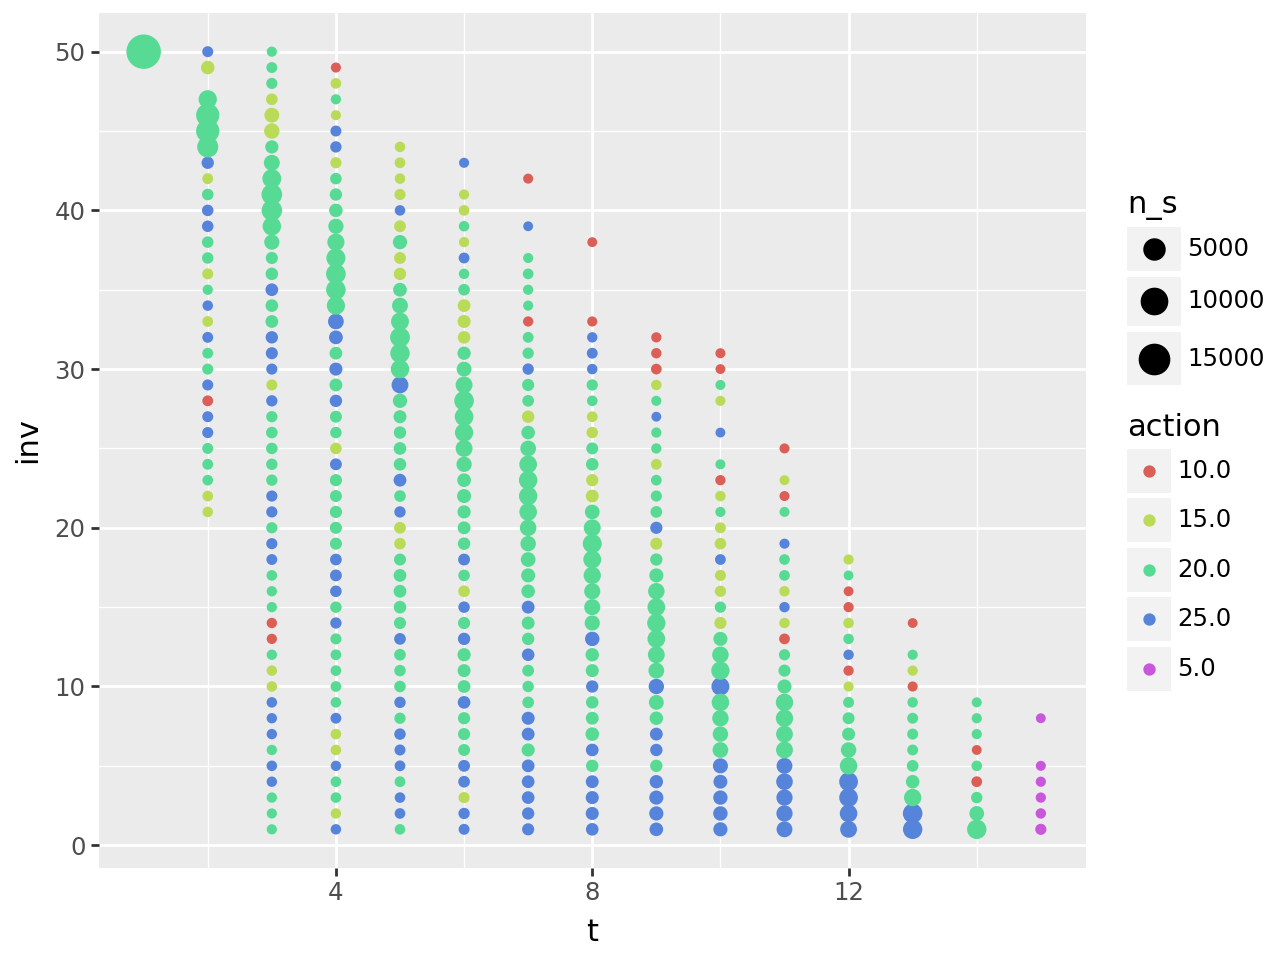

In [ ]:
visits = dat_rl >> group_by(X.state) >> summarize(n_s = X.n.sum())
df = (
    dat_rl
    >> group_by(X.state)
    >> mutate(q_rank = min_rank(X.q, ascending=False))
    >> mask(X.q_rank == 1, X.n != 0)
    >> left_join(visits)
)

pt = (
    ggplot(df, aes(x = 't', y = 'inv', size = 'n_s', color = 'action')) +
        geom_point()
)
pt.show()

Observe that the states are now sampled differently. Some states are visited many times (many episodes visit that state) while others are not visited often. For the states visited often we have a better approximation of best action compared to states which are visited rarely. Here the action is more or less random, e.g. at $t=3$ som actions set the price to 10 (setting the price to 25 would be better since we only have few items left).



## Exercises


###  Exercise - Seasonal inventory and sales planning

Consider the seasonal product in the [seasonal inventory and sales planning example](https://bss-osca.github.io/rl/09_mc.html#sec-mc-seasonal).



#### Q1

Consider the plot with the optimal policy for the MDP. Here, the optimal price is high at the lower-left and decreases as we approach the upper-right. Explain why this, from an intuitive point of view, seems correct.

<details>
   <summary>Solution</summary>
   With a low inventory level, there is a high probability of selling everything even for the highest price. This effect is more dominant if the number of time-steps left is high and decrease as we approach week 15. Contrary with a high inventory level there is a low probability of selling everything (if the price is set to high) and therefore we have to use a lower price. This effect is more dominant if the number of time-steps left is low.
</details>

#### Q2

Consider the plot of the optimal policy for the MDP. For a fixed time $t$, the optimal price does not always decrease as the inventory level increases. Sometimes two prices oscillate (e.g. first green, then red and then green again). Give possible reasons for this happening.

<details>
   <summary>Solution</summary>
   The optimal policy is found using a threshold value, i.e the MDP finds an optimal policy with state-values within the threshold. Hence, small differences in state-value may produce different optimal prices. Another reason could be that we have multiple optimal policies.
</details>


#### Q3

3) Let us consider two extreme states $(1,1)$ and $(100,14)$. From an intuitively point of view, what is the optimal action/price to do in these states?

<details>
   <summary>Solution</summary>
   In state $(1,1)$ the optimal price is 25 (we only have one item left to sell over 15 weeks) and in state $(100,14)$ the optimal price is 10 (we can not sell all items in one week, so set a low price.
</details>

#### Q4

Consider state $(1,1)$ and let us try approximating best epsilon-greedy policy using MC with the verbose option so it prints out info about each episode:

In [ ]:
np.random.seed(232)  # reproducibility
time = 1  # initial week
i = 1  # initial inventory
state = f"{i},{time}"

agent.gpi_on_policy_mc(
    env,
    min_ite=10,      # minimum iterations before convergence check
    max_ite=50000,   # hard cap on iterations
    states=[state],  # focus on start state (like states = state)
    reset=True,      # reset Q and counters
    eps=0.2,         # ε-greedy behavior
    theta=0.2,       # convergence tolerance
    verbose=True,    # no per-episode prints
)

dat_rl = (
    agent.get_action_values()
    >> separate(X.state, into = ["inv", "t"], remove = False, convert = True)
)

# Let us consider the action-values
dat_rl >> mask(X.inv == i, X.t == time) >> left_join(dat_mdp)

Episode:
     s     a    r    g  n_sa  old_q  step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   1.0    0.0   1.0    6.0    0.0    5.1
Episode:
     s     a    r    g  n_sa  old_q      step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   2.0    6.0  0.707107    6.0    5.1    5.1
Episode:
     s     a    r    g  n_sa  old_q     step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   3.0    6.0  0.57735    6.0    5.1    5.1
Episode:
     s     a    r    g  n_sa  old_q  step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   4.0    6.0   0.5    6.0    5.1    5.1
Episode:
     s     a    r    g  n_sa  old_q      step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   5.0    6.0  0.447214    6.0    5.1    5.1
Episode:
     s     a    r    g  n_sa  old_q      step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   6.0    6.0  0.408248    6.0    5.1    5.1
Episode:
     s     a    r    g  n_sa  old_q      step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   7.0    6.0  0.377964    6.0    5.1    5.1
Episode:
     s  

/usr/local/lib/python3.12/dist-packages/dfply/reshape.py:130: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


,state,action,q,n,inv,t,v
0,"1,1",10.0,0.0,0,1,1.0,NaN
1,"1,1",15.0,0.0,0,1,1.0,NaN
2,"1,1",20.0,6.0,10,1,1.0,NaN
3,"1,1",25.0,0.0,0,1,1.0,11.0


Why do we not estimate the optimal action here, and why does the algorithm stop? Hint: You may have a look at the GPI method used in the RLAgent class.

<details>
   <summary>Solution</summary>
   Since the epsilon-greedy policy selects $a=20$ (at random) first, $a=20$ becomes the greedy action that is selected with highest probability. In this run, when selecting the next action, 20 is always selected and hence only $q$ for $a=20$ is updated 10 times (minimum number of iterations). Afterwards differences in state-values of states in the current episode are compared (`old_v` and `v` column). Since they are the same, the algorithm stops. That is, we never get a chance to have a view on action $a=25$ or put differently, the stopping criteria may not work well for episodes with small length. You may try to increase `min_ite` to 1000 and see what happens.
</details>

#### Q5



Let us try to set the action-value high initially:



In [ ]:
agent = RLAgent()  # create agent
agent.add_states(env.get_states())  # add states
for s in agent.get_state_keys():  # loop over states
    agent.add_actions(s, env.get_actions(s))  # add available actions for each state
print(agent.get_info())

np.random.seed(105)  # reproducibility

time = 1  # initial week
i = 1  # initial inventory
state = f"{i},{time}"
agent.set_action_value(1000)
agent.set_action_ctr_value(0)
agent.set_state_ctr_value(0)
agent.get_action_values(state)

agent.gpi_on_policy_mc(
    env,
    min_ite=10,      # minimum iterations before convergence check
    max_ite=50000,   # hard cap on iterations
    states=[state],  # focus on start state (like states = state)
    reset=False,      # reset Q and counters
    eps=0.2,         # ε-greedy behavior
    theta=0.2,       # convergence tolerance
    verbose=True,    # no per-episode prints
)

dat_rl = (
    agent.get_action_values()
    >> separate(X.state, into = ["inv", "t"], remove = False, convert = True)
)

# Let us consider the action-values at the state
dat_rl >> mask(X.inv == i, X.t == time) >> left_join(dat_mdp)

{'states': 1501, 'actions': 5701}
Episode:
     s     a    r    g  n_sa   old_q  step  new_q   old_v  new_v
0  1,1  10.0 -4.0 -4.0   1.0  1000.0   1.0   -4.0  1000.0  949.8
Episode:
     s     a     r     g  n_sa   old_q  step  new_q  old_v   new_v
0  1,1  25.0  11.0  11.0   1.0  1000.0   1.0   11.0  949.8  900.35
Episode:
     s     a     r     g  n_sa  old_q      step  new_q   old_v   new_v
0  1,1  25.0  11.0  11.0   2.0   11.0  0.707107   11.0  900.35  900.35
Episode:
     s     a    r    g  n_sa   old_q  step  new_q   old_v  new_v
0  1,1  15.0  1.0  1.0   1.0  1000.0   1.0    1.0  900.35  850.4
Episode:
     s     a    r    g  n_sa   old_q  step  new_q  old_v  new_v
0  1,1  20.0  6.0  6.0   1.0  1000.0   1.0    6.0  850.4    9.5
Episode:
     s     a     r     g  n_sa  old_q     step  new_q  old_v  new_v
0  1,1  25.0  11.0  11.0   3.0   11.0  0.57735   11.0    9.5    9.5
Episode:
     s     a     r     g  n_sa  old_q  step  new_q  old_v  new_v
0  1,1  25.0  11.0  11.0   4.0   11.0 

/usr/local/lib/python3.12/dist-packages/dfply/reshape.py:130: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


,state,action,q,n,inv,t,v
0,"1,1",10.0,-4.0,2,1,1.0,NaN
1,"1,1",15.0,1.0,1,1,1.0,NaN
2,"1,1",20.0,6.0,1,1,1.0,NaN
3,"1,1",25.0,11.0,6,1,1.0,11.0


What happens with the sequence of episodes?
<details>
   <summary>Solution</summary>
   Since the initial action-value is high, all actions will be explored with high probability first. This may help the algorithm get a good start.
</details>

#### Q6

Consider state $(1,1)$ and let us try approximating best epsilon-greedy policy using MC using more episodes:


In [ ]:
np.random.seed(749)

agent.gpi_on_policy_mc(env, min_ite=100, states=[state], reset=True, eps=0.2)
print(f"State-value at state {state}:", agent.get_state_value_q(state))
agent.gpi_on_policy_mc(env, min_ite=500, states=[state], reset=True, eps=0.2)
print(f"State-value at state {state}:", agent.get_state_value_q(state))
agent.gpi_on_policy_mc(env, min_ite=1000, states=[state], reset=True, eps=0.2)
print(f"State-value at state {state}:", agent.get_state_value_q(state))

GPI algorithm finished in 100 iterations.
State-value at state 1,1: 9.322402489388857
GPI algorithm finished in 501 iterations.
State-value at state 1,1: 9.21385498906481
GPI algorithm stopped at max iterations allowed: 1000
GPI algorithm finished in 1000 iterations.
State-value at state 1,1: 9.39071850787669



Why is the state-value not increasing monotone as number of iterations increase?


<details>
   <summary>Solution</summary>
   Since we do simulations (we here do 3) each simulation may produce different results Depending on how the algorithm starts. That is, we need more iterations to reach the correct state-value.
</details>

#### Q7

Consider state $(25,8)$ and let us approximate the best epsilon-greedy policy:



In [ ]:
np.random.seed(281)  # reproducibility

time = 8  # initial week
i = 25  # initial inventory
state = f"{i},{time}"
agent.set_action_value(1000)
agent.set_action_ctr_value(0)
agent.set_state_ctr_value(0)
agent.get_action_values(state)

agent.gpi_on_policy_mc(
    env,
    min_ite=5000,      # minimum iterations before convergence check
    max_ite=50000,   # hard cap on iterations
    states=[state],  # focus on start state (like states = state)
    reset=False,      # reset Q and counters
    eps=0.5         # ε-greedy behaviour
)

dat_rl = (
    agent.get_action_values()
    >> separate(X.state, into = ["inv", "t"], remove = False, convert = True)
)

# Let us consider the action-values at the state
dat_rl >> mask(X.inv == i, X.t == time) >> left_join(dat_mdp)

GPI algorithm finished in 5172 iterations.


/usr/local/lib/python3.12/dist-packages/dfply/reshape.py:130: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


,state,action,q,n,inv,t,v
0,"25,8",10.0,297.129904,105,25,8.0,NaN
1,"25,8",15.0,441.144240,148,25,8.0,NaN
2,"25,8",20.0,491.342658,4783,25,8.0,502.367276
3,"25,8",25.0,468.550541,136,25,8.0,NaN


As can be seen the optimal state value for the MDP is not equal the action-value for that action. Should that have been the case if run enough simulations?


<details>
   <summary>Solution</summary>
   No, the q-values are the averages over all the generated episodes (also those generated using bad policies). With enough simulations these numbers will converge against the action-values for the best epsilon-greedy policy ($\epsilon = 0.5$ here), not the optimal greedy policy.
</details>

#### Q8

Consider the very optimistic policy, which sets the price to 25 (where possible):



In [ ]:
import re

agent = RLAgent()  # create agent
agent.add_states(env.get_states())  # add states
for s in agent.get_state_keys():  # loop over states
    agent.add_actions(s, env.get_actions(s))  # add available actions for each state
print(agent.get_info())

# Set policy
states = [s for s in agent.get_state_keys() if s != "0"]  # all states except terminal "0"
states = [s for s in states if not re.search(r",15$", s)]  # states without ",15" (all weeks except last)
pi = {"25": 1.0}  # always set price 25
agent.set_policy(states, pi)
states = [s for s in states if re.search(r",15$", s)]  # states at last time-step (",15")
pi = {"5": 1.0}  # scrap price at last week
agent.set_policy(states, pi)
pi = {"dummy": 1.0}  # terminal state "0"
agent.set_policy(["0"], pi)
display(agent.get_policy())

{'states': 1501, 'actions': 5701}


,state,action,pr
0,"1,1",25,1.0
1,"1,2",25,1.0
2,"1,3",25,1.0
3,"1,4",25,1.0
4,"1,5",25,1.0
...,...,...,...
1396,"100,11",25,1.0
1397,"100,12",25,1.0
1398,"100,13",25,1.0
1399,"100,14",25,1.0


We may generate an episode using:



In [ ]:
env.get_episode_pi(agent, "5,1")

,s,a,r
0,"5,1",25,-45.0
1,"4,2",25,0.0
2,"4,3",25,25.0
3,"3,4",25,25.0
4,"2,5",25,25.0
5,"1,6",25,25.0


Let us try to evaluate this policy in states $(5,1)$ and $(100,10)$:



In [ ]:
np.random.seed(678)

state = "5,1"
agent.policy_eval_mc(env, states=[state])
print(f"State-value at state {state}:\n", agent.get_state_values([state]))
print(f"State-value MDP at state {state}:\n", mdp.get_state_values([state]))
state = "100,10"
agent.policy_eval_mc(env, states=[state])
print(f"State-value at state {state}:\n", agent.get_state_values([state]))
print(f"State-value MDP at state {state}:\n", mdp.get_state_values([state]))

Policy eval algorithm finished in 100 iterations.
State-value at state 5,1:
   state     v
0   5,1  55.0
State-value MDP at state 5,1:
   state          v
0   5,1  54.999858
Policy eval algorithm finished in 209 iterations.
State-value at state 100,10:
     state           v
0  100,10  579.330144
State-value MDP at state 100,10:
     state            v
0  100,10  1000.545716


Why do we have state-values close and not close to the optimal values for the MDP?

<details>
   <summary>Solution</summary>
   For state $(5,1)$ it is optimal to set the price high for all states in the sample-path and we estimate the optimal policy. For state $(100,10)$ it is not optimal to set the price high, i.e. the state-value we estimate here is not the optimal one.
</details>